### Experiments setup

In [1]:
import numpy as np
import pandas as pd
import torch
import torchtuples as tt
from pycox import datasets
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime

np.random.seed(1234)
_ = torch.manual_seed(123)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
df = datasets.metabric.read_df()
feat_cols = ["x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]
feats = df[feat_cols]
surv_label = df[["duration", "event"]].values

0:	[0s / 0s],		train_loss: 0.6948,	val_loss: 0.6586
1:	[0s / 0s],		train_loss: 0.6753,	val_loss: 0.6534
2:	[0s / 0s],		train_loss: 0.6422,	val_loss: 0.6095
3:	[0s / 0s],		train_loss: 0.6184,	val_loss: 0.6064
4:	[0s / 0s],		train_loss: 0.6359,	val_loss: 0.5872
5:	[0s / 0s],		train_loss: 0.6370,	val_loss: 0.5850
6:	[0s / 0s],		train_loss: 0.6344,	val_loss: 0.5912
7:	[0s / 0s],		train_loss: 0.6262,	val_loss: 0.5928
8:	[0s / 0s],		train_loss: 0.6245,	val_loss: 0.5994
9:	[0s / 0s],		train_loss: 0.5842,	val_loss: 0.6049
10:	[0s / 0s],		train_loss: 0.6018,	val_loss: 0.5958
11:	[0s / 0s],		train_loss: 0.6303,	val_loss: 0.5888
12:	[0s / 0s],		train_loss: 0.6197,	val_loss: 0.5990
13:	[0s / 0s],		train_loss: 0.6218,	val_loss: 0.5940
14:	[0s / 0s],		train_loss: 0.6134,	val_loss: 0.5796
15:	[0s / 0s],		train_loss: 0.6212,	val_loss: 0.5861
16:	[0s / 0s],		train_loss: 0.6231,	val_loss: 0.5815
17:	[0s / 0s],		train_loss: 0.6183,	val_loss: 0.5922
18:	[0s / 0s],		train_loss: 0.6161,	val_loss: 0.5903
19:

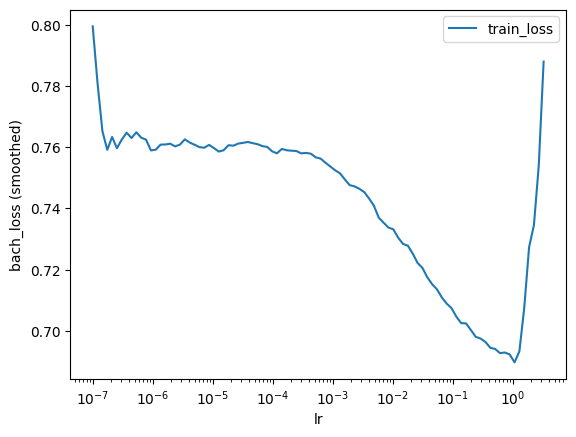

In [3]:
# Split data
df_val = df.sample(frac=0.2)
df_train = df.drop(df_val.index)

x_train = df_train[feat_cols].values
x_val = df_val[feat_cols].values

y_train = (df_train['duration'].values, df_train['event'].values)
y_val = (df_val['duration'].values, df_val['event'].values)
val = tt.tuplefy(x_val, y_val)

# Train the model
in_features = x_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

estimator = CoxTime(net, tt.optim.Adam)

batch_size = 256
lrfinder = estimator.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

estimator.optimizer.set_lr(0.01)
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

log = estimator.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())

_ = estimator.compute_baseline_hazards()

In [4]:
# Load model explainer
from src.explainer import explainer
model_explainer = explainer(estimator, feats, surv_label)

### Prediction

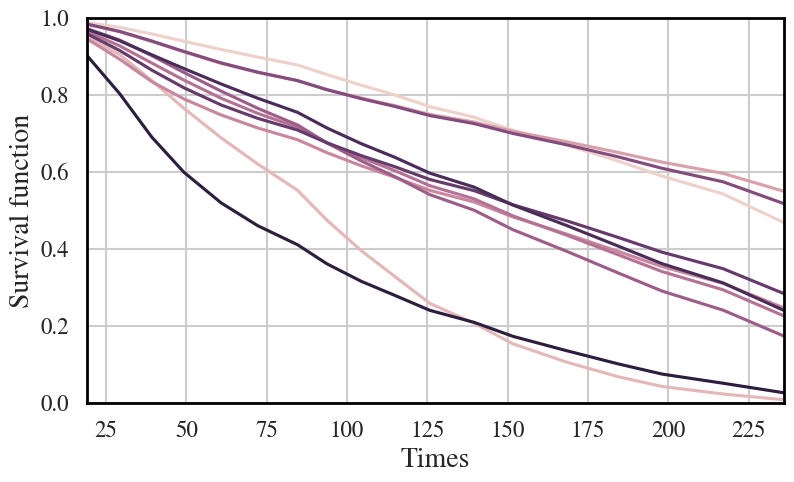

In [5]:
from src import prediction
# select first 10 observations to be explained
explained_data = feats[:10]
# Survival prediction
surv_pred = prediction.predict(model_explainer, explained_data)
prediction.plot_prediction(surv_pred, "survival")

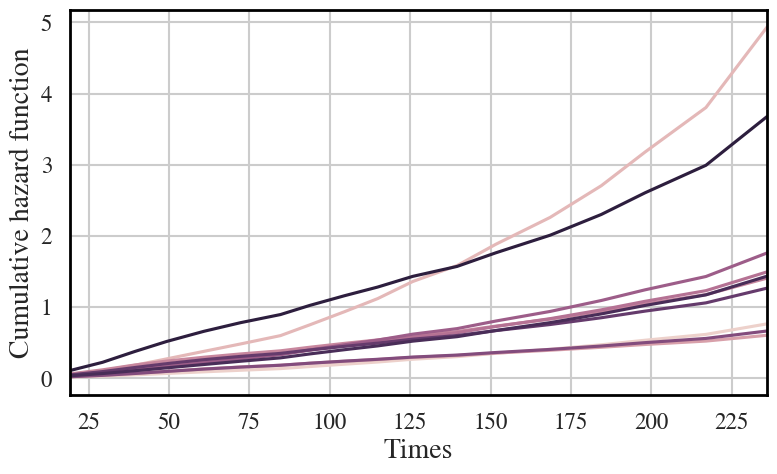

In [6]:
# Cumulative hazard prediction
chf_pred = prediction.predict(model_explainer, explained_data, type="chf")
prediction.plot_prediction(chf_pred, "chf")

### Performance

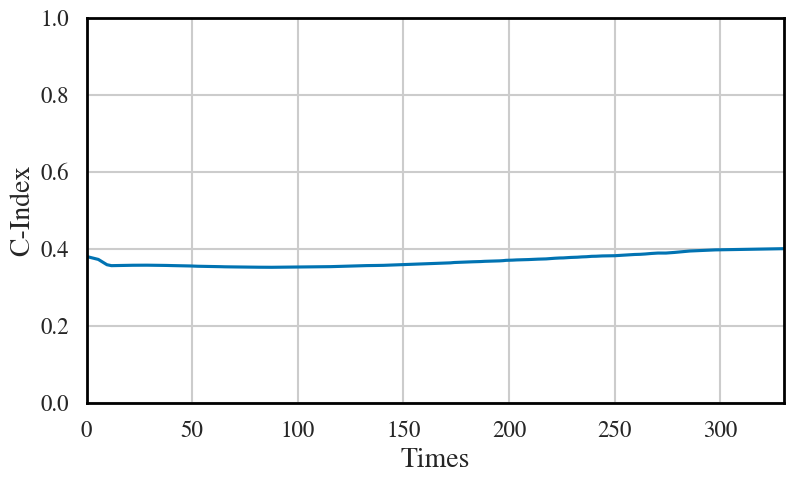

In [7]:
from src import performance
eval_times = np.unique(surv_label[:, 0])[::10]

# C-Index evaluation
cindex_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="c_index")
performance.plot_performance(cindex_perf, metric="c_index")

In [8]:
print(cindex_perf.head(20))

        times      perf
0    0.000000  0.379341
1    2.500000  0.375813
2    5.500000  0.371831
3    9.600000  0.358039
4   11.700000  0.355628
5   14.166667  0.355932
6   15.366667  0.356334
7   16.600000  0.356375
8   18.233334  0.356536
9   19.566668  0.356575
10  20.666666  0.356675
11  21.933332  0.356650
12  23.366667  0.356740
13  24.333334  0.356794
14  25.466667  0.356812
15  27.200001  0.356828
16  28.566668  0.356837
17  29.666666  0.356783
18  30.866667  0.356709
19  31.799999  0.356654


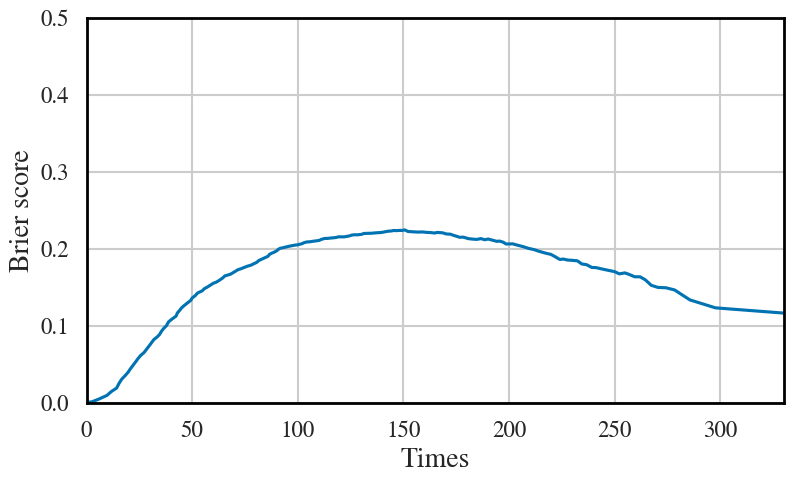

In [9]:
# Brier score evaluation
bs_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="brier_score")
performance.plot_performance(bs_perf, metric="brier_score")

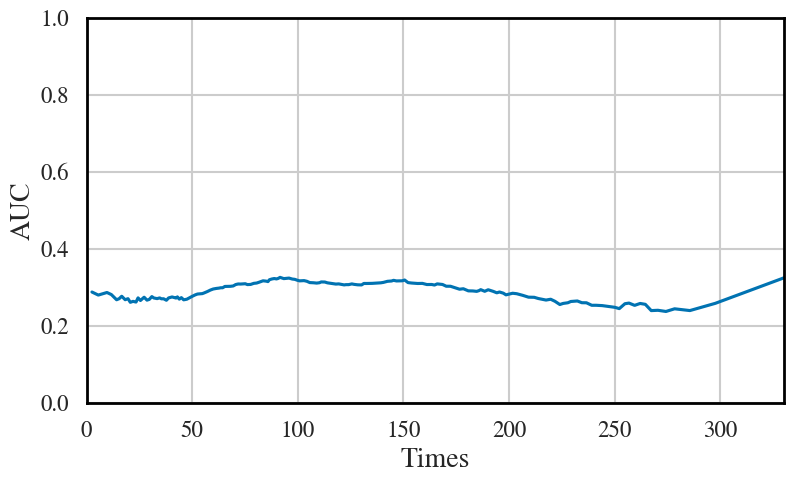

In [10]:
# AUC evaluation
auc_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="auc")
performance.plot_performance(auc_perf, metric="auc")

### Local explaination

In [11]:
from src import local_explaination

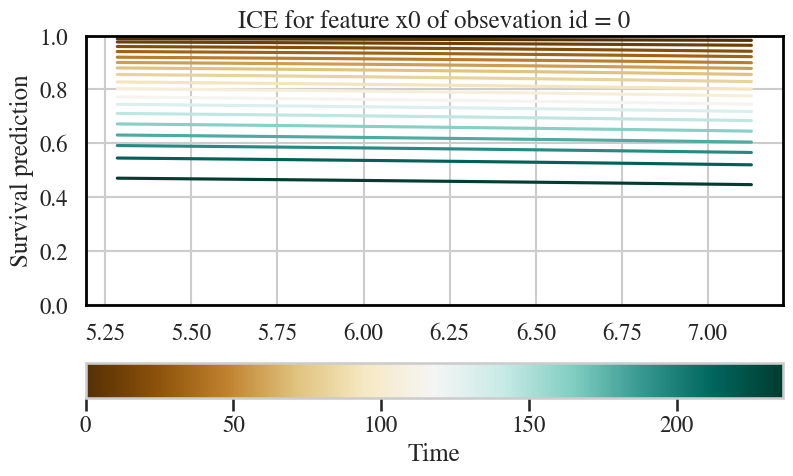

In [12]:
# individual conditional expectation
explained_feature = "x0"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature, 
                                                               n_sel_samples=10, 
                                                               n_grid_points=10)
local_explaination.plot_ICE(ICE_df, explained_feature)

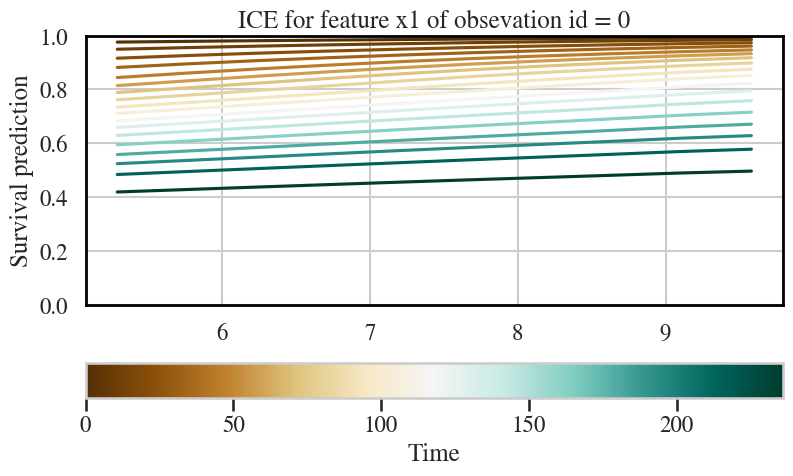

In [13]:
# individual conditional expectation
explained_feature = "x1"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature, 
                                                               n_sel_samples=10, 
                                                               n_grid_points=10)
local_explaination.plot_ICE(ICE_df, explained_feature)

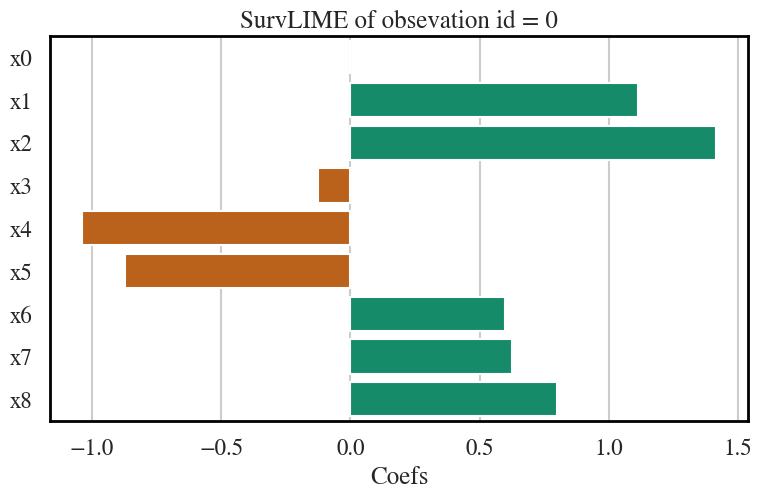

In [14]:
# SurvLIME
SurvLIME_df = local_explaination.SurvLIME(model_explainer, explained_data, surv_label, 100)
local_explaination.plot_SurvLIME(SurvLIME_df)

### Global explaination

In [15]:
from src import global_explaination

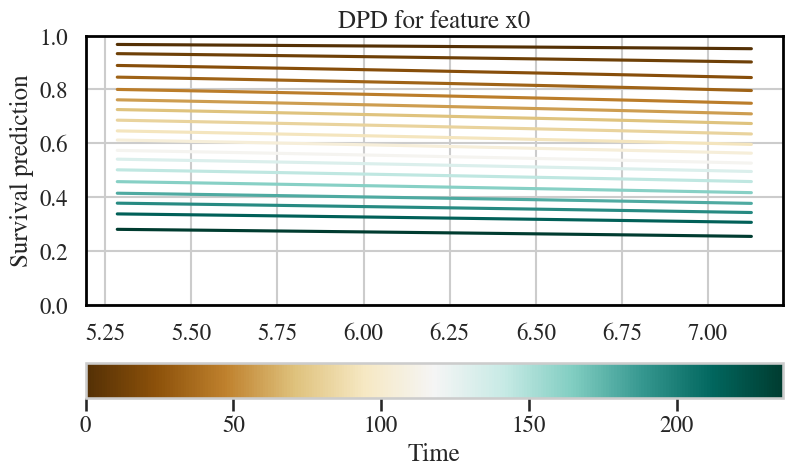

In [16]:
# partial dependence plot
explained_feature = "x0"
PDP_df = global_explaination.partial_dependence_plots(model_explainer, explained_feature, n_sel_samples=10)
global_explaination.plot_PDP(PDP_df)

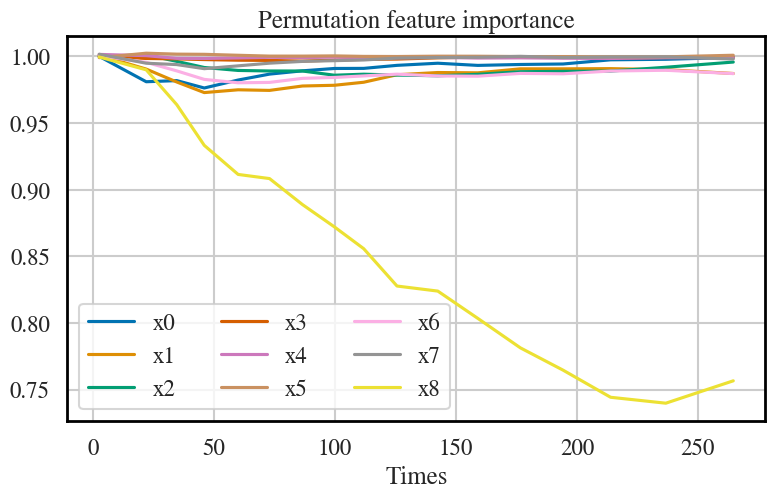

In [17]:
# permuatation feature importance
eval_times = np.unique(surv_label[:, 0])[10::100]
feat_importance_df = global_explaination.permutation_feature_importance(model_explainer, feats, 
                                                                        surv_label, eval_times=eval_times, 
                                                                        n_perm=3)
global_explaination.plot_PFI(feat_importance_df)